# **Final Project - Image Captioning**

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from nltk.translate.bleu_score import sentence_bleu , corpus_bleu


seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

# Download the dataset
We will be using the training part of Vizwiz dataset for our model.
This dataset has 23,431 images, that are each paired with five different captions (117,155 captions).

In [2]:
!wget -q https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip
!unzip -qq train.zip
!wget -q http://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip
!unzip -qq annotations.zip
!rm train.zip annotations.zip

In [3]:
import json
# Opening JSON file
with open("/content/annotations/train.json","r") as read_file:
  data = json.load(read_file)

In [4]:
# Path to the images
IMAGES_PATH = "train"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 20
AUTOTUNE = tf.data.AUTOTUNE

# Organization the data to dictionary
keys = img names : values = five captions

In [5]:
# Organization the data to dict of name : caption
def organization_data(file_name):

  img_name_list=[]
  caption_list=[]
  ca_list=[]
  dics={}

  imgs=file_name.get('images')
  anno=file_name.get('annotations')

  for index in range(len(imgs)):
      img=imgs[index]
      img_name = img.get('file_name')
      img_name = os.path.join(IMAGES_PATH, img_name) ####
      img_name_list.append(img_name)

  for index2 in range(len(anno)):
      cap=anno[index2]
      caption=cap.get('caption')
      caption="<start> " + caption + " <end>"
      caption_list.append(caption)
#make list of lists with 5 captions in each
  for i in range(len(imgs)):
    cap_list=[]
    for y in range(5):
      cap_list.append(caption_list[5*i+y])
    ca_list.append(cap_list)

  data_dict={}

  for key in img_name_list:
      for value in ca_list:
          data_dict[key] = value
          ca_list.remove(value)

          break
          
  return data_dict, img_name_list, caption_list

data_dict, img_name_list, caption_list = organization_data(data)

Split the dataset into train, validation and test sets

In [6]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

# Split the dataset into training and validation sets
train_data, test_data = train_val_split(data_dict,train_size=0.6)
test_data, valid_data = train_val_split(test_data,train_size=0.55)

print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))
print("Number of test samples: ", len(test_data))

Number of training samples:  14058
Number of validation samples:  4218
Number of test samples:  5155


# Vectorizing the text data

In [7]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(caption_list)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image

In [8]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

test_dataset = make_dataset(list(test_data.keys()), list(test_data.values()))


## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features - EfficientNetB0.
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
3. A TransformerDecoder: This model takes the encoder output and the text data

In [9]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

16719872/16705208 [==============================] - 0s 0us/step


# Model training

In [10]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy, metrics=["accuracy"])

# Fit the model
hist = caption_model.fit(
       train_dataset,
       epochs=EPOCHS,
       validation_data=valid_dataset,
       callbacks=[early_stopping],
   ).history

Epoch 1/20
220/220 [==============================] - 354s 1s/step - loss: 24.1741 - acc: 0.2101 - val_loss: 18.6460 - val_acc: 0.3957
Epoch 2/20
220/220 [==============================] - 342s 2s/step - loss: 17.7739 - acc: 0.4003 - val_loss: 16.9766 - val_acc: 0.4269
Epoch 3/20
220/220 [==============================] - 342s 2s/step - loss: 16.3614 - acc: 0.4282 - val_loss: 16.2139 - val_acc: 0.4382
Epoch 4/20
220/220 [==============================] - 315s 1s/step - loss: 15.4810 - acc: 0.4429 - val_loss: 15.7738 - val_acc: 0.4456
Epoch 5/20
220/220 [==============================] - 314s 1s/step - loss: 14.8315 - acc: 0.4541 - val_loss: 15.5090 - val_acc: 0.4500
Epoch 6/20
220/220 [==============================] - 314s 1s/step - loss: 14.3019 - acc: 0.4637 - val_loss: 15.3136 - val_acc: 0.4542
Epoch 7/20
220/220 [==============================] - 341s 2s/step - loss: 13.8648 - acc: 0.4704 - val_loss: 15.1901 - val_acc: 0.4560
Epoch 8/20
220/220 [==============================] - 3

# Loss & Accuracy

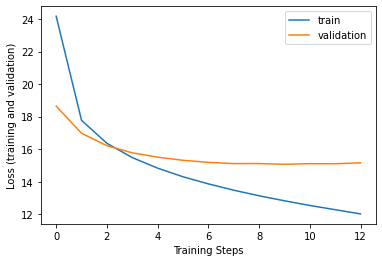

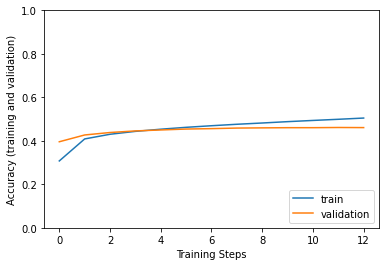

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(['train', 'validation'], loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.legend(['train', 'validation'], loc='lower right')

# Scores

BLEU scores

In [12]:
def Split(words,N):
  s=[]
  for i in range(len(words)-N+1):
    for n in range(N):
      x=words[i:i+N]
      y = [" ".join(x)]
    s.append(y)
  return s

def belu(references,candidates,N=1):
  can=Split(candidates,N)
  ref=[]
  count=[]
  for index in range(len(references)):
    ref.append(Split(references[index],N))
  for r in ref:
    counter=0
    for x in can:
      if x in r:
        counter+=1
        r.remove(x)
    count.append(counter)
  score=max(count)
  scorebelu=score/len(can)
  return scorebelu

In [13]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

test_image_list = list(test_data.keys())
test_captions_list = list(test_data.values())


def Predicted_Caption(test_image):

    # Select a random image from the test dataset

    # Read the image from the disk
    sample_img = decode_and_resize(test_image)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    
    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    return decoded_caption

In [18]:
#1.1
def BLEU_scores(test_image_list,test_captions_list,num_img=10):
  belu1_score = belu2_score = belu3_score = belu4_score = 0

  for i in range(num_img):
    candidate = []
    reference = []

    pick = np.random.randint(len(test_image_list))
    test_image_name = test_image_list[pick] # string of the name of the image
    test_caption = test_captions_list[pick] # list of the 5 captions

    decoded = Predicted_Caption(test_image_name) # string of predicted caption
    candidate=decoded.split()

    for index in range(5):
        x1=[]
        x1 = test_caption[index].split()
        x1.remove("<start>")
        x1.remove("<end>")
        reference.append(x1) # make list of lists of refernce cations
      
    ref=[]
    ref2=[]
    for y in reference:
      for x in y:
        s=x.replace('.','')
        ref.append(s.lower())
      ref2.append(ref)
      ref=[]
    
    reference=ref2

    belu1_score += belu(reference, candidate,N=1)
    belu2_score += belu(reference, candidate,N=2)
    belu3_score += belu(reference, candidate,N=3)
    belu4_score += belu(reference, candidate,N=4)


  belu1_score = belu1_score/num_img
  belu2_score = belu2_score/num_img
  belu3_score = belu3_score/num_img
  belu4_score = belu4_score/num_img

  print('BLEU-1 score : %f' % belu1_score)
  print('BLEU-2 score : %f' % belu2_score)
  print('BLEU-3 score : %f' % belu3_score)
  print('BLEU-4 score : %f' % belu4_score)

BLEU_scores(test_image_list,test_captions_list,num_img=1000)

BLEU-1 score : 0.531555
BLEU-2 score : 0.286758
BLEU-3 score : 0.181846
BLEU-4 score : 0.128153


# Check sample predictions

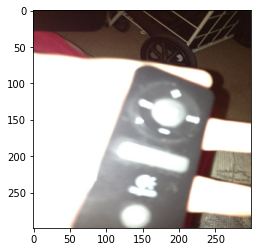

Predicted Caption:  a white box with a white and black buttons and


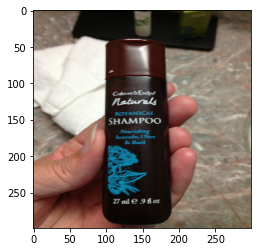

Predicted Caption:  a person is holding a bottle of hair conditioner


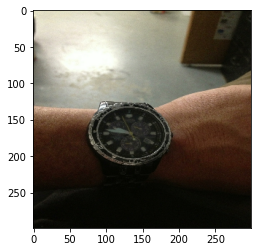

Predicted Caption:  a silver watch on a persons wrist with a silver watch


In [61]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
test_images = list(test_data.keys())


def generate_caption():
    # Select a random image from the test dataset
    sample_img = np.random.choice(test_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()